### Imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import json
import saliency
tfk  = tf .keras
tfkl = tfk.layers
import skimage
from skimage.segmentation import felzenszwalb as segment
from sklearn.metrics import auc

from utils import *
from tf_dataset_load_custom import image_dataset_from_directory
from guided_ig import *
from tqdm import tqdm

### Fetch the dataset.

Not stored in RAM (>150 GB), but mapped out with labels by Tensorflow.

In [2]:
width  = 299
height = 299
batch_size = 32
dataset = image_dataset_from_directory(
    '/media/big/imagenet/data/ILSVRC/Annotations/CLS-LOC/train', # Change as necessary
    '/media/big/imagenet/data/ILSVRC/Data/CLS-LOC/train-bbox',   # Change as necessary
    batch_size = batch_size,
    image_size = (width, height)
)

Found 544546 files belonging to 1000 classes.
Found 544546 files belonging to 1000 classes.


2021-12-05 16:26:11.647149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 16:26:11.667590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 16:26:11.667881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 16:26:11.669208: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Load labels.

In [3]:
with open('imagenet_class_index.json', 'r') as fp:
    label_json = json.loads(fp.read())
labels = np.array([
    [k, *v]
    for k, v in label_json.items()
])

### Load model.

Here, using Inception V3.

In [4]:
model = tf.keras.applications.InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### Sanity check - does the model work?

Run a few batches. Note the necessary preprocessing. Also gives an idea of time commitment.

In [5]:
%%time
batches = 100
res = []

for x, y, i in dataset.map(preprocess_iv3).take(batches):
    p = model(x)
    res.append(p.numpy().argmax(1) == y.numpy())
    
res = np.concatenate(res)
print(f'Top-1 accuracy of {batches * batch_size} samples: {res.mean()}')

2021-12-05 16:27:22.047078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2021-12-05 16:27:22.496046: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Top-1 accuracy of 3200 samples: 0.906875
CPU times: user 27.3 s, sys: 1.96 s, total: 29.2 s
Wall time: 14.3 s


### Second sanity check: plot some images with predictions.

Preprocessing is to $[-1, 1]$ range. $[0, 1]$ is required for plotting.

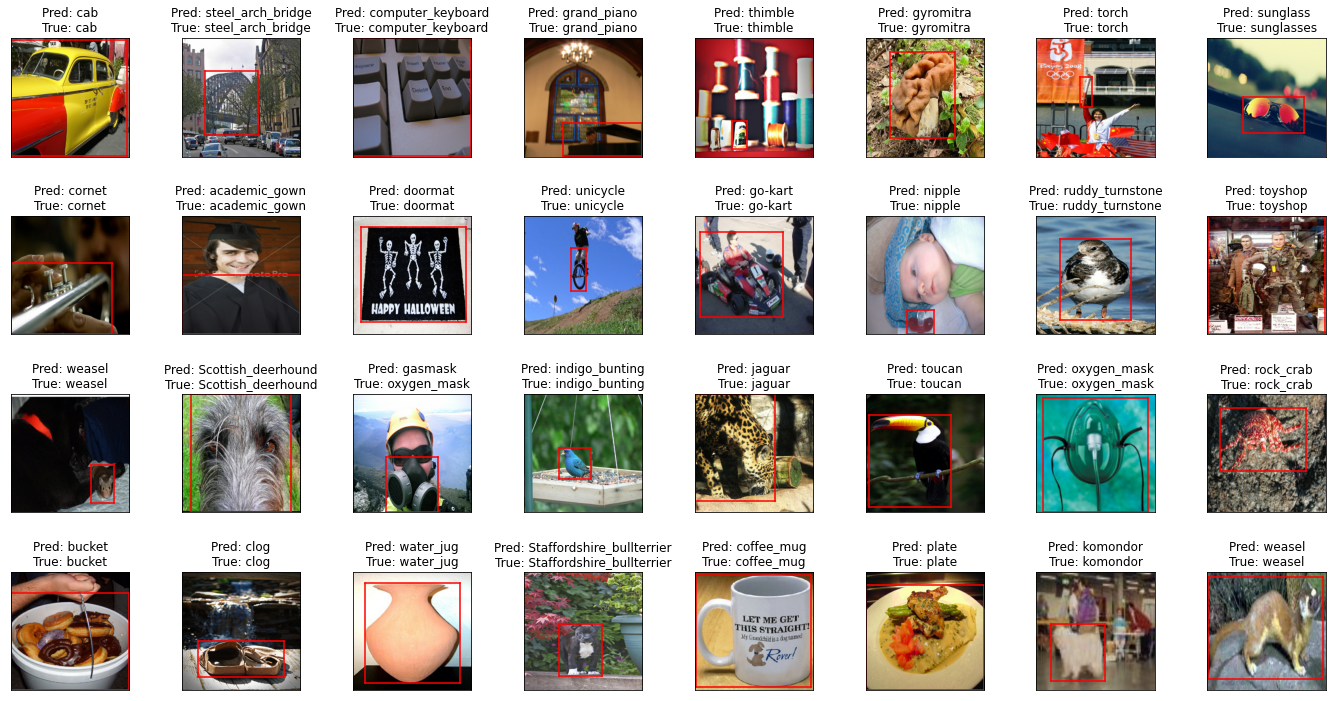

In [6]:
def bbox_plot(ax, xmin, xmax, ymin, ymax):
    ax.plot([xmin, xmax], [ymin, ymin], 'r')
    ax.plot([xmin, xmin], [ymin, ymax], 'r')
    ax.plot([xmin, xmax], [ymax, ymax], 'r')
    ax.plot([xmax, xmax], [ymin, ymax], 'r')

rows = 4
cols = 8
plt.figure(figsize = (3 * cols, 3 * rows))
plt.subplots_adjust(hspace = 0.5)
for images, ys, bboxes in dataset.map(preprocess_iv3).take(1):
    p = labels[model(images).numpy().argmax(1), 2]
    for idx, (im, l, y, xmin, xmax, ymin, ymax) in enumerate(zip(images, p, ys, *bboxes)):
        plt.subplot(rows, cols, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow((im + 1) / 2)
        bbox_plot(plt, xmin, xmax, ymin, ymax)
        plt.title(f'Pred: {l}' + '\n' + f'True: {labels[y, 2]}')
plt.show()

### Very first experiment: show GIG using official implementation, IG with simple custom implementation.

In [7]:
def grad_func(x, idx):
    x = tf.constant(x)[tf.newaxis]
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        pred = pred[:, idx]
    return np.squeeze(tape.gradient(pred, x).numpy())

Note high computation time. Reducing steps can help.

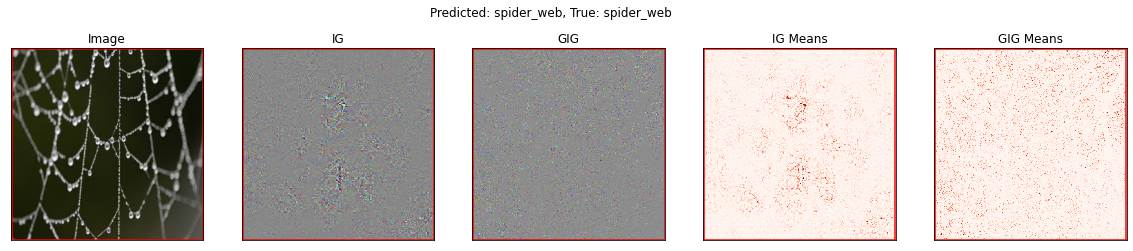

CPU times: user 7.77 s, sys: 355 ms, total: 8.13 s
Wall time: 5.71 s


In [8]:
%%time
n = 1
for images, ys, bbox in dataset.map(preprocess_iv3).take(1):
    for im, y, xmin, xmax, ymin, ymax in zip(images[:n], ys[:n], *bbox):

        # GIG
        x_baseline = tf.zeros_like(im)
        steps = 32
        fraction = 0.1
        idx = tf.argmax(tf.reshape(model(im[tf.newaxis]), -1))

        gig = unbounded_guided_ig(
            im.numpy(),
            x_baseline.numpy(), 
            steps, 
            lambda x: grad_func(x, idx), 
            fraction
        )

        # IG
        inp = im[tf.newaxis] * tf.cast(
            tf.reshape(
                tf.linspace(0, 1, steps), 
                (steps, 1, 1, 1)), 
            im.dtype
        )
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
            pred = pred[:, idx]
        grad = tape.gradient(pred, inp)
        ig = tf.reduce_sum(grad, 0).numpy()
        
        # THINGS TO PLOT
        imp  = (im + 1) / 2
        
        igm  = to_unitrange( ig.mean(-1))
        gigm = to_unitrange(gig.mean(-1))
        
        ig  = to_unitrange(ig)
        gig = to_unitrange(gig) 
        
        show = [
            ('Image', lambda: plt.imshow(
                imp
            )),
            ('IG',    lambda: plt.imshow(
                ig,  interpolation = 'none'
            )),
            ('GIG',   lambda: plt.imshow(
                gig, interpolation = 'none'
            )),
            ('IG Means',  lambda: plt.imshow(
                igm,  interpolation = 'none', cmap = 'Reds', vmin =  igm.mean()
            )),
            ('GIG Means', lambda: plt.imshow(
                gigm, interpolation = 'none', cmap = 'Reds', vmin = gigm.mean()
            )),
        ]
        
        plt.figure(figsize = (4 * len(show), 4))
        for jdx, (title, lam) in enumerate(show):
            plt.subplot(1, len(show), jdx + 1)
            bbox_plot(plt, xmin, xmax, ymin, ymax)
            lam()
            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f'Predicted: {labels[idx, 2]}, True: {labels[y, 2]}')
        plt.show()

### Attempting to blur images as in XRAI paper. 

https://arxiv.org/abs/1906.02825

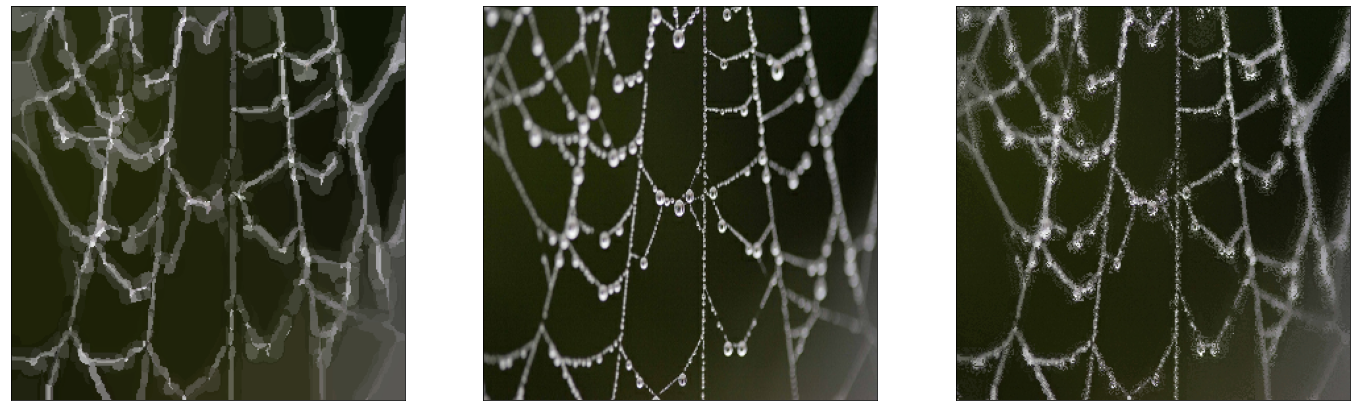

CPU times: user 7.2 s, sys: 312 ms, total: 7.51 s
Wall time: 6.83 s


In [9]:
%%time

# Documentation: Next cell

img = im.numpy()

masks = saliency.core.xrai._get_segments_felzenszwalb(img)
smasks = np.stack(masks)
_, realseg = np.unique(
    smasks.reshape((len(masks), -1)), 
    axis = 1, 
    return_inverse = True
)
realseg = realseg.reshape((img.shape[:-1]))
seg_img = np.zeros_like(img)
for idx in np.unique(realseg):
    mask = realseg == idx
    seg_img[mask] = img[mask].mean(0)
    
plt.figure(figsize = (24, 8))
plt.subplot(131)
plt.imshow(to_unitrange(seg_img))
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(to_unitrange(img))
plt.xticks([])
plt.yticks([])
plt.subplot(133)
show = seg_img.copy()
mask = gigm > np.quantile(gigm, 0.5)
show[mask] = img[mask]
plt.imshow(to_unitrange(show))
plt.xticks([])
plt.yticks([])
plt.show()

### A single, full, SIC sample evaluation.

In [10]:
%%time

im_numpy = im.numpy()

# Evaluate model
model_res = model(im_numpy[np.newaxis]).numpy().flatten()
# Softmax and winning class
best_idx, softmax = model_res.argmax(), model_res.max()

# Perform GIG, B + W baseline
gig = np.stack([
    unbounded_guided_ig(
        im_numpy,
        baseline, 
        200, 
        lambda x: grad_func(x, best_idx), 
        0.1
    )
    for baseline in [
        np.zeros_like(im_numpy) - 1, # To the model, black is -1
        np.ones_like (im_numpy)      # White is 1
    ]
]).mean((0, -1))

# Construct "blurred" (from oversegmented) image
masks = saliency.core.xrai._get_segments_felzenszwalb(im_numpy)
smasks = np.stack(masks)
_, realseg = np.unique(
    smasks.reshape((len(masks), -1)), 
    axis = 1, 
    return_inverse = True
)
realseg = realseg.reshape((im_numpy.shape[:-1]))
seg_img = np.zeros_like(im_numpy)
for idx in np.unique(realseg):
    mask = realseg == idx
    seg_img[mask] = im_numpy[mask].mean(0)
    
# Reintroduce salient pixels
# Unspecified method; take ~50% (> 0)
mask = gig > np.quantile(gig, 0.5)
seg_img[mask] = im_numpy[mask]

# Softmax comparison
model_res   = model(seg_img[np.newaxis]).numpy().flatten()
alt_softmax = model_res[best_idx]
y = alt_softmax / softmax

# "Entropy" (webp size, haha what) comparison
p1 = 'test1.WEBP'
p2 = 'test2.WEBP'
plt.imsave(p1, to_unitrange(seg_img))
plt.imsave(p2, to_unitrange(im_numpy))
x = os.path.getsize(p1) / os.path.getsize(p2)
os.remove(p1)
os.remove(p2)

# Resulting tuple
(x, y)

CPU times: user 47.3 s, sys: 300 ms, total: 47.6 s
Wall time: 47 s


(1.483478546769686, 1.0174896)

In [37]:
qs = np.linspace(0.0, 1.0, 5)

ress = []

for q in qs:
    
    inbox = lambda samples, xmin, xmax, ymin, ymax: (
        (samples > [xmin, ymin]) & 
        (samples < [xmax, ymax])
    ).all(1)

    pos = np.argwhere(gig  < np.quantile(gig, q))
    neg = np.argwhere(gig >= np.quantile(gig, q))
    TP  = inbox(pos, xmin, xmax, ymin, ymax).sum()
    FP  = pos.shape[0] - TP
    FN  = inbox(neg, xmin, xmax, ymin, ymax).sum()
    TN  = neg.shape[0] - FN
    ress.append((TP / (TP + FN), FP / (FP + TN)))
    
ress = np.array(ress)
arr = np.array(ress).T
auc([0, *arr[0], 1], [0, *arr[1], 1]), auc(arr[0], arr[1])

(0.6507019649532567, 0.6506905515127892)